In [7]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine, text
import os
import json

#!pip install "cloud-sql-python-connector[pg8000]"
from google.cloud.sql.connector import Connector

In [8]:
def loadJSON(path):
    """
    Returns data from JSON file @ path
    """
    return json.load(open(path))

In [9]:
# Create engine
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/content/googleCloudKey.json'

def initPostgreSQL():
    """
    Connects and initializes PostgreSQL
    """
    # Import database creditations
    creds = loadJSON("/content/postgreSQLKey.json")

    def getConnection():
        connector = Connector()
        connection = connector.connect(
            creds["connectionName"],
            "pg8000",
            user=creds["user"],
            password=creds["password"],
            db=creds["dbname"]
        )
        return connection
    
    try: # Try to connecto to database
        engine = create_engine(
            "postgresql+pg8000://",
            creator=getConnection,
        )
        return engine
    except Exception as e: # Connection failed
        return None

In [10]:
# Get engine
engine = initPostgreSQL()

In [21]:
query = text("""
   SELECT l.name AS league_name, t.id AS team_id, t.name AS team_name,
       SUM(CASE WHEN m.home_team_id = t.id THEN m.home_goals ELSE 0 END) AS goals_for,
       SUM(CASE WHEN m.away_team_id = t.id THEN m.away_goals ELSE 0 END) AS goals_against,
       SUM(CASE WHEN m.home_team_id = t.id AND m.home_goals > m.away_goals THEN 3
                WHEN m.away_team_id = t.id AND m.away_goals > m.home_goals THEN 3
                WHEN m.home_goals = m.away_goals AND (m.home_team_id = t.id OR m.away_team_id = t.id) THEN 1
                ELSE 0
           END) AS points
FROM leagues l
JOIN teams t ON l.id = t.league_id
JOIN matches m ON (m.home_team_id = t.id OR m.away_team_id = t.id) AND m.league_id = l.id
GROUP BY l.name, t.id, t.name
ORDER BY l.name, points DESC, (SUM(CASE WHEN m.home_team_id = t.id THEN m.home_goals ELSE 0 END) - SUM(CASE WHEN m.away_team_id = t.id THEN m.away_goals ELSE 0 END)) DESC;
""")
with engine.connect() as connection:
  df = pd.read_sql_query(query, connection)

print(df.head(18))

   league_name  team_id            team_name  goals_for  goals_against  points
0   Bundesliga     9789    Borussia Dortmund         33             21      53
1   Bundesliga     8149         Union Berlin         24             18      51
2   Bundesliga     9823        Bayern Mnchen         35             30      49
3   Bundesliga   178475           Rb Leipzig         28             22      48
4   Bundesliga     8358          Sc Freiburg         22             16      47
5   Bundesliga     8178     Bayer Leverkusen         28             21      43
6   Bundesliga     9810  Eintracht Frankfurt         28             20      41
7   Bundesliga     8721            Wolfsburg         26             18      39
8   Bundesliga     9788   Borussia Mgladbach         29             13      35
9   Bundesliga     9905             Mainz 05         20             17      35
10  Bundesliga     8697        Werder Bremen         23             19      32
11  Bundesliga     8722            1 Fc Köln        

In [9]:
# Load data
query = text("""
SELECT
    t.name AS team_name,
    SUM(m.home_goals) AS home_goals,
    SUM(m.away_goals) AS away_goals,
    SUM(m.home_goals + m.away_goals) AS total_goals
FROM
    teams t
JOIN
    matches m ON (t.id = m.home_team_id OR t.id = m.away_team_id)
GROUP BY
    t.name
ORDER BY
    total_goals DESC;
""")
with engine.connect() as connection:
  df = pd.read_sql_query(query, connection)

print(df.head(5))

     team_name  home_goals  away_goals  total_goals
0       Troyes          56          46          102
1      Arsenal          53          48          101
2       Monaco          45          53           98
3  Montpellier          50          46           96
4     Toulouse          51          43           94


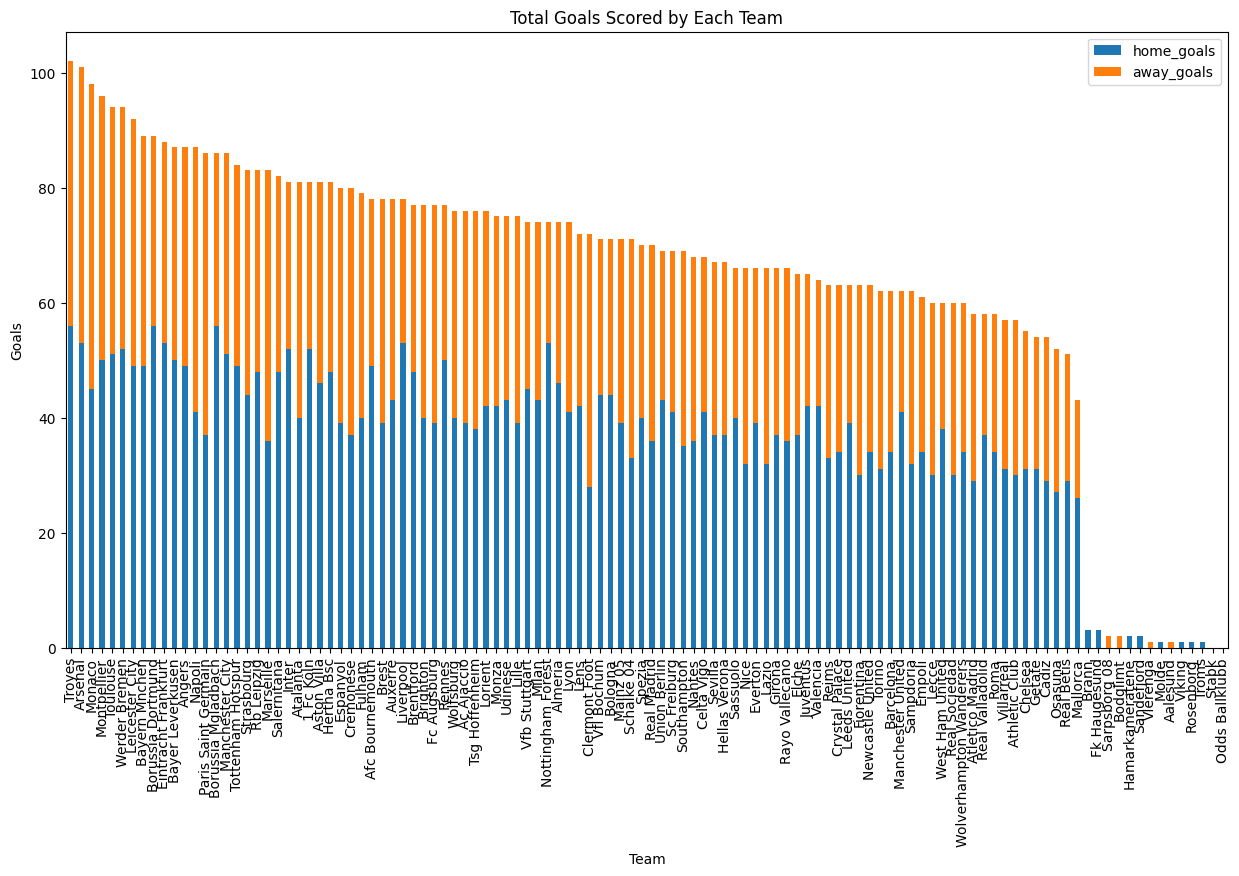

In [25]:
# Assuming you have the SQL query result stored in a variable called 'result1'
data1 = pd.DataFrame(df, columns=["team_name", "home_goals", "away_goals", "total_goals"])

# Create a stacked bar chart
data1.plot(x="team_name", y=["home_goals", "away_goals"], kind="bar", stacked=True, figsize=(15, 8))

# Add labels and title
plt.xlabel("Team")
plt.ylabel("Goals")
plt.title("Total Goals Scored by Each Team")

# Display the plot
plt.show()

              team_name  goal_diff
0                Napoli         45
1       Manchester City         44
2             Barcelona         44
3               Arsenal         43
4         Bayern Mnchen         41
5   Paris Saint Germain         38
6                  Lens         28
7                 Lazio         26
8             Marseille         25
9      Newcastle United         23
10          Real Madrid         22
11             Juventus         21
12               Monaco         20
13      Atletico Madrid         20
14    Borussia Dortmund         19


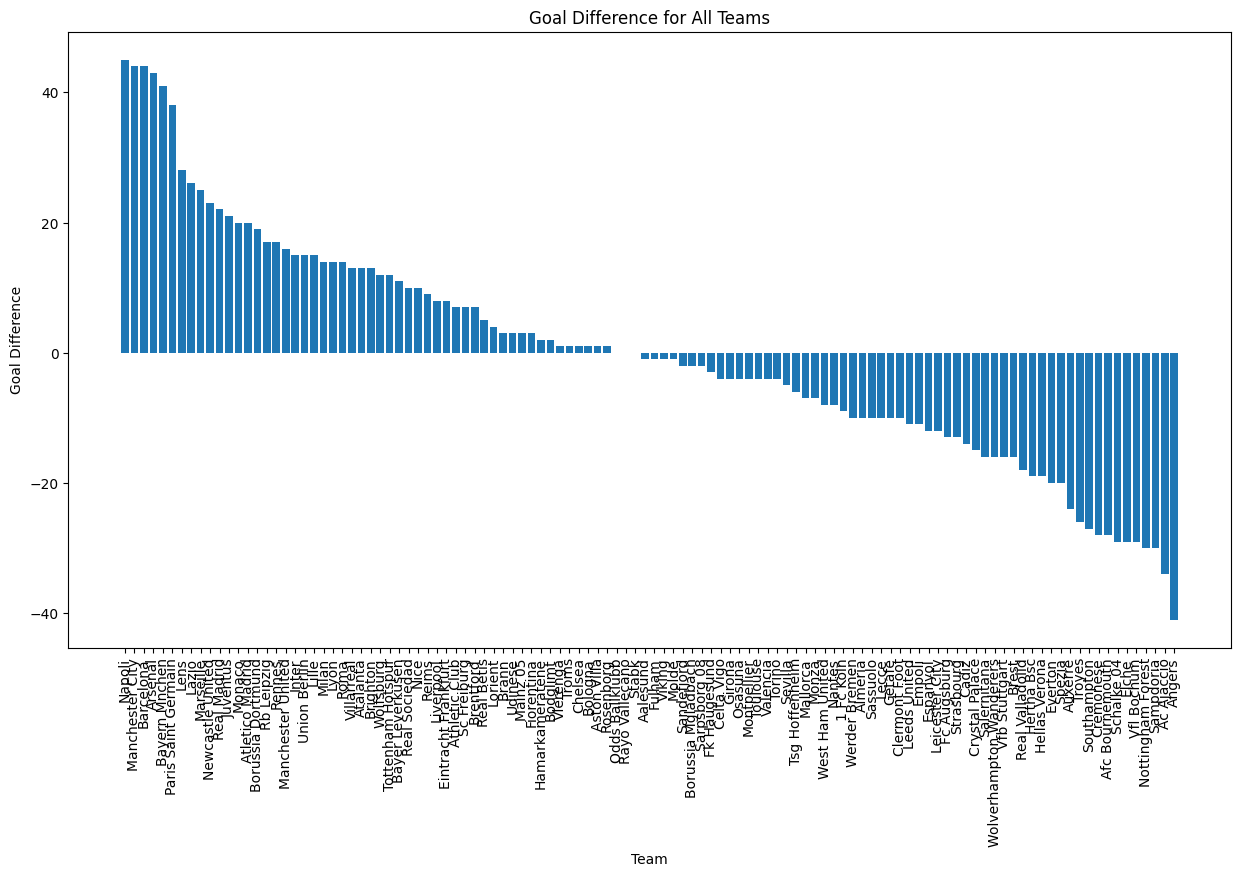

In [15]:
# Load data
query = text("""
  SELECT
    t.name AS team_name,
    SUM(CASE WHEN m.home_team_id = t.id THEN m.home_goals - m.away_goals ELSE m.away_goals - m.home_goals END) AS goal_diff
FROM
    teams t
    INNER JOIN matches m ON t.id = m.home_team_id OR t.id = m.away_team_id
GROUP BY
    t.name
ORDER BY
    goal_diff DESC;

""")
with engine.connect() as connection:
  df = pd.read_sql_query(query, connection)

print(df.head(15))

plt.figure(figsize=(15, 8))
plt.bar(df['team_name'], df['goal_diff'])
plt.xticks(rotation=90)
plt.title('Goal Difference for All Teams')
plt.xlabel('Team')
plt.ylabel('Goal Difference')
plt.show()

In [30]:
# Load data
query = text("""
SELECT
    p.name AS player_name,
    t.name AS team_name,
    p.goals AS goals_scored
FROM
    players p
JOIN
    teams t ON p.team_id = t.id
ORDER BY
    goals_scored DESC
LIMIT 10;
""")
with engine.connect() as connection:
  df = pd.read_sql_query(query, connection)

print(df.head(5))

            player_name            team_name  goals_scored
0  Erling Braut Haaland      Manchester City            30
1           Chuba Akpom        Middlesbrough            26
2             Andy Cook        Bradford City            24
3  Jonson Clarke Harris  Peterborough United            24
4            Harry Kane    Tottenham Hotspur            23
5        Victor Osimhen               Napoli            21
6          Kylian Mbapp  Paris Saint Germain            19
7        Jonathan David                Lille            19
8          Colby Bishop           Portsmouth            19
9         Conor Chaplin         Ipswich Town            19


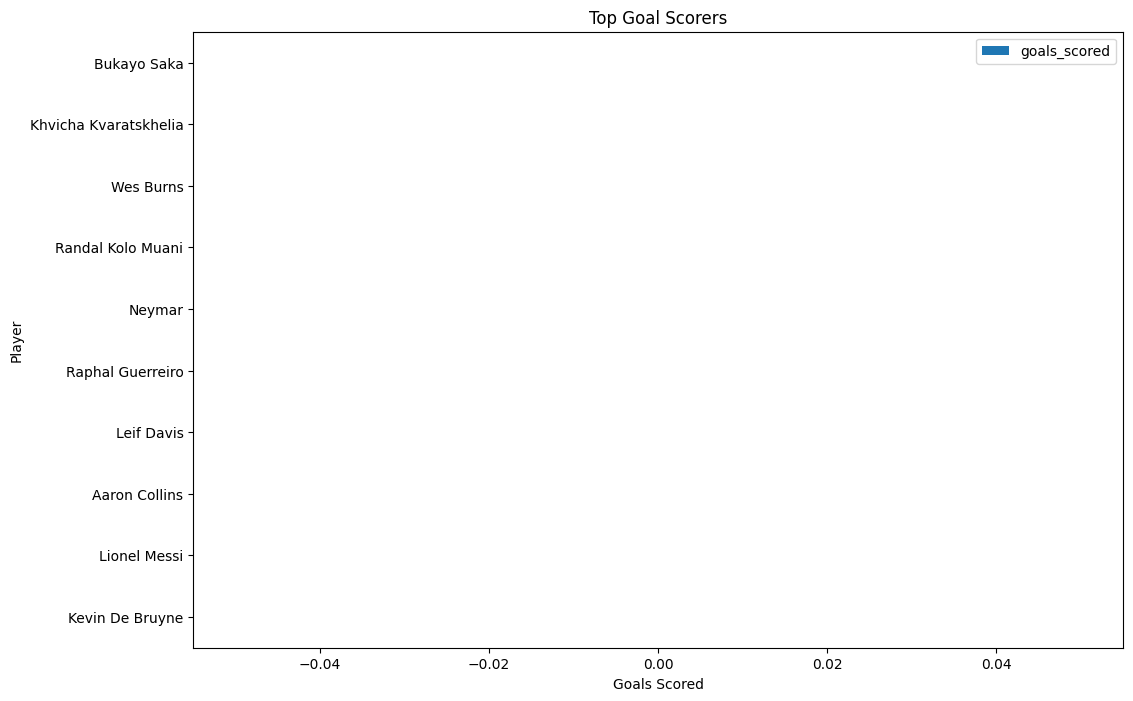

In [33]:
# Assuming you have the SQL query result stored in a variable called 'result2'
data2 = pd.DataFrame(df, columns=["player_name", "team_name", "goals_scored"])

# Create a horizontal bar chart
data2.plot(x="player_name", y="goals_scored", kind="barh", figsize=(12, 8))

# Add labels and title
plt.xlabel("Goals Scored")
plt.ylabel("Player")
plt.title("Top Goal Scorers")

# Display the plot
plt.show()


In [31]:
# Load data
query = text("""
SELECT
    p.name AS player_name,
    t.name AS team_name,
    p.assists AS assists_count
FROM
    players p
JOIN
    teams t ON p.team_id = t.id
ORDER BY
    assists_count DESC
LIMIT 10;
""")
with engine.connect() as connection:
  df = pd.read_sql_query(query, connection)

print(df.head(5))

        player_name            team_name  assists_count
0   Kevin De Bruyne      Manchester City             14
1      Lionel Messi  Paris Saint Germain             14
2     Aaron Collins       Bristol Rovers             11
3        Leif Davis         Ipswich Town             11
4  Raphal Guerreiro    Borussia Dortmund             11


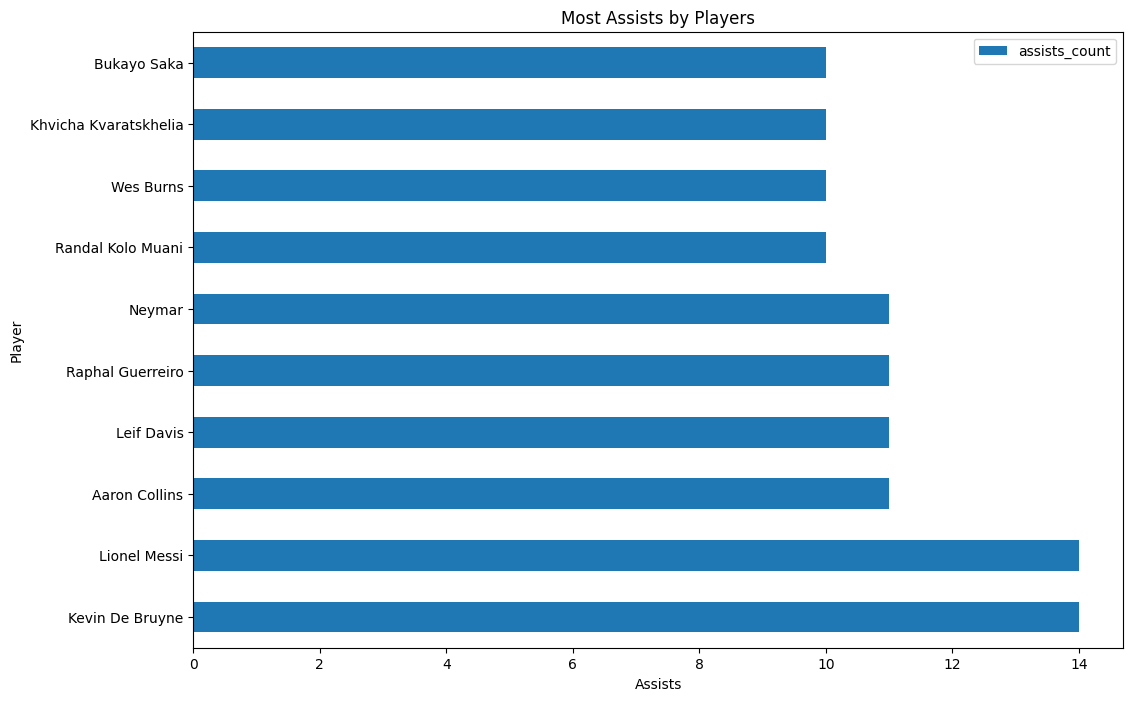

In [34]:
# Assuming you have the SQL query result stored in a variable called 'result3'
data3 = pd.DataFrame(df, columns=["player_name", "team_name", "assists_count"])

# Create a horizontal bar chart
data3.plot(x="player_name", y="assists_count", kind="barh", figsize=(12, 8))

# Add labels and title
plt.xlabel("Assists")
plt.ylabel("Player")
plt.title("Most Assists by Players")

# Display the plot
plt.show()

In [35]:
# Load data
query = text("""
SELECT
    p.country AS nationality,
    COUNT(p.id) AS player_count
FROM
    players p
GROUP BY
    nationality
ORDER BY
    player_count DESC;
""")
with engine.connect() as connection:
  df = pd.read_sql_query(query, connection)

print(df.head(5))

  nationality  player_count
0     England           897
1       Spain           295
2      France           273
3     Germany           188
4       Italy           180


In [ ]:
# Assuming you have the SQL query result stored in a variable called 'result5'
data5 = pd.DataFrame(df, columns=["nationality", "player_count"])

# Create a bar chart
data5.plot(x="nationality", y="player_count", kind="bar", figsize=(15, 8))

# Add labels and title
plt.xlabel("Nationality")
plt.ylabel("Player Count")
plt.title("Most Common Player Nationalities")

# Display the plot
plt.show()

In [11]:
# Load data
query = text("""
SELECT 
    leagues.name as league_name,
    COUNT(matches.id) as total_matches,
    SUM(CASE WHEN home_goals > away_goals THEN 1 ELSE 0 END) as home_wins,
    SUM(CASE WHEN home_goals = away_goals THEN 1 ELSE 0 END) as draws,
    SUM(CASE WHEN home_goals < away_goals THEN 1 ELSE 0 END) as away_wins
FROM matches
JOIN leagues ON matches.league_id = leagues.id
GROUP BY leagues.name;
""")
with engine.connect() as connection:
  df = pd.read_sql_query(query, connection)

print(df.head(5))

      league_name  total_matches  home_wins  draws  away_wins
0     Eliteserien              7          4      1          2
1         Seria A            285        117     75         93
2      Bundesliga            235        109     58         68
3          LaLiga            266        117     68         81
4  Premier League            283        133     67         83


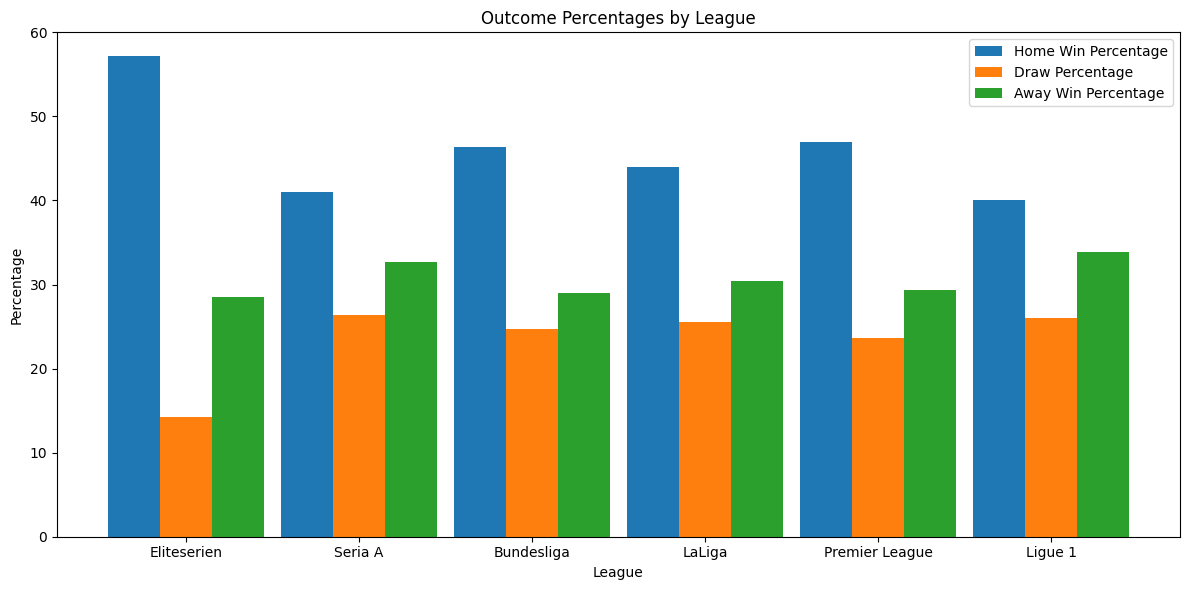

In [12]:
# Plot data

df['home_win_percentage'] = (df['home_wins'] / df['total_matches']) * 100
df['draw_percentage'] = (df['draws'] / df['total_matches']) * 100
df['away_win_percentage'] = (df['away_wins'] / df['total_matches']) * 100

n_leagues = len(df)
index = np.arange(n_leagues)
bar_width = 0.3

fig, ax = plt.subplots(figsize=(12, 6))

rects1 = ax.bar(index, df['home_win_percentage'], bar_width, label='Home Win Percentage')
rects2 = ax.bar(index + bar_width, df['draw_percentage'], bar_width, label='Draw Percentage')
rects3 = ax.bar(index + 2 * bar_width, df['away_win_percentage'], bar_width, label='Away Win Percentage')

ax.set_xlabel('League')
ax.set_ylabel('Percentage')
ax.set_title('Outcome Percentages by League')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(df['league_name'])
ax.legend()

fig.tight_layout()
plt.show()

In [19]:
# Load data
query = text("""
WITH match_count AS (
    SELECT
        team_id,
        COUNT(*) AS total_matches
    FROM (
        SELECT home_team_id AS team_id FROM matches
        UNION ALL
        SELECT away_team_id AS team_id FROM matches
    ) AS subquery
    GROUP BY team_id
),
win_count AS (
    SELECT
        team_id,
        COUNT(*) AS total_wins
    FROM (
        SELECT home_team_id AS team_id FROM matches WHERE home_goals > away_goals
        UNION ALL
        SELECT away_team_id AS team_id FROM matches WHERE away_goals > home_goals
    ) AS subquery
    GROUP BY team_id
),
team_win_rate AS (
    SELECT
        mc.team_id,
        1.0 * wc.total_wins / mc.total_matches * 100 AS win_rate
    FROM
        match_count mc
    JOIN
        win_count wc ON mc.team_id = wc.team_id
),
team_avg_rating AS (
    SELECT
        t.id AS team_id,
        AVG(ps.rating) AS avg_rating
    FROM
        players p
    JOIN
        playerstats ps ON p.id = ps.player_id
    JOIN
        matches m ON ps.match_id = m.id
    JOIN
        teams t ON p.team_id = t.id
    WHERE
        ((m.home_team_id = t.id AND m.home_goals > m.away_goals)
        OR (m.away_team_id = t.id AND m.away_goals > m.home_goals))
        AND ps.rating > 0
    GROUP BY
        t.id
)
SELECT
    t.name AS team_name,
    tar.avg_rating,
    twr.win_rate
FROM
    teams t
JOIN
    team_avg_rating tar ON t.id = tar.team_id
JOIN
    team_win_rate twr ON t.id = twr.team_id
ORDER BY
    avg_rating DESC;
""")
with engine.connect() as connection:
  df = pd.read_sql_query(query, connection)

print(df.head(186))

                   team_name  avg_rating    win_rate
0                      Brann    8.128333  100.000000
1                  1 Fc Köln    7.706909   25.925926
2              Bayern Mnchen    7.693644   58.333333
3                   Bodglimt    7.690000  100.000000
4            Hamarkameratene    7.632857  100.000000
..                       ...         ...         ...
99            Leicester City    7.136739   23.333333
100  Wolverhampton Wanderers    7.102778   27.586207
101               Ac Ajaccio    7.096341   20.000000
102                Cremonese    7.086296    6.896552
103            Hellas Verona    6.997619   17.241379

[104 rows x 3 columns]


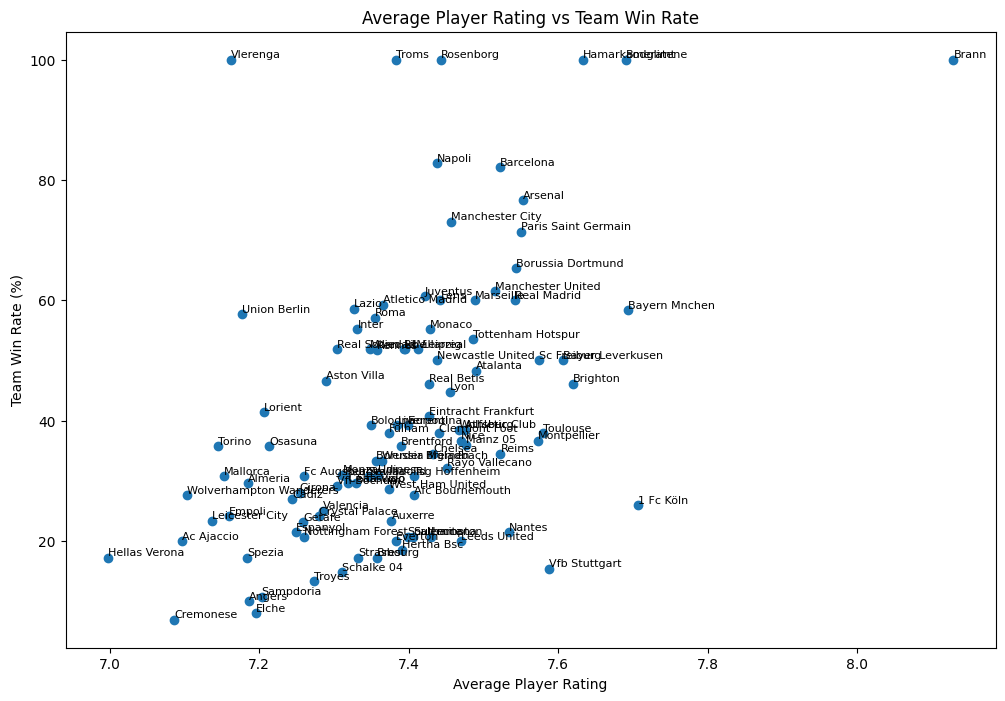

In [21]:
# Create a DataFrame from the result
data = pd.DataFrame(df, columns=["team_name", "avg_rating", "win_rate"])

# Create a scatter plot
plt.figure(figsize=(12, 8))
plt.scatter(data["avg_rating"], data["win_rate"])

# Add labels for each data point
for index, row in data.iterrows():
    plt.text(row["avg_rating"], row["win_rate"], row["team_name"], fontsize=8, ha='left', va='bottom')

# Add labels and title
plt.xlabel("Average Player Rating")
plt.ylabel("Team Win Rate (%)")
plt.title("Average Player Rating vs Team Win Rate")

# Display the plot
plt.show()

In [60]:
# Load data
query = text("""
WITH player_match_stats AS (
    SELECT
        p.id AS player_id,
        p.name AS player_name,
        COUNT(DISTINCT ps.match_id) AS total_matches,
        SUM(ps.goals) AS total_goals
    FROM
        players p
        INNER JOIN playerstats ps ON p.id = ps.player_id
    GROUP BY
        p.id
),
player_goals_per_match AS (
    SELECT
        player_id,
        player_name,
        total_goals,
        total_matches,
        total_goals * 1.0 / total_matches AS goals_per_match
    FROM
        player_match_stats
)
SELECT
    player_name,
    total_goals,
    total_matches,
    ROUND(goals_per_match, 2) AS goals_per_match
FROM
    player_goals_per_match
ORDER BY
    goals_per_match DESC
LIMIT 50;

""")
with engine.connect() as connection:
  df = pd.read_sql_query(query, connection)

print(df.head(50))

             player_name  total_goals  total_matches  goals_per_match
0          Ole Kolskogen          NaN              1              NaN
1   Lorenzo De Silvestri          NaN              1              NaN
2            Svenn Crone          NaN              1              NaN
3       Frederik Brsting          8.0              1             8.00
4           Henrik Udahl          8.0              1             8.00
5         Borja Iglesias          4.0              1             4.00
6          Memphis Depay          4.0              1             4.00
7         Vincent Sierro          4.0              1             4.00
8         Adrian Pereira          4.0              1             4.00
9   Sivert Heltne Nilsen          4.0              1             4.00
10           Ellis Simms          4.0              1             4.00
11            Lois Diony          4.0              1             4.00
12     Ikoma Lois Openda         18.0              5             3.60
13         Ciro Immo

In [67]:
# Load data
query = text("""
SELECT
    player_id,
    match_id,
    COUNT(*)
FROM
    playerstats
GROUP BY
    player_id,
    match_id
HAVING
    COUNT(*) > 1;
""")
with engine.connect() as connection:
  df = pd.read_sql_query(query, connection)

print(df.head(100000))

       player_id  match_id  count
0         699362   3904436      2
1          40685   3904564      4
2         169193   3904635      2
3         575779   3900974      2
4         980793   3904606      2
...          ...       ...    ...
17790     177714   3903629      2
17791     490868   3901016      4
17792     438456   3919476      2
17793     362195   3919183      2
17794     956682   3901223      4

[17795 rows x 3 columns]


In [78]:
# Load data
query = text("""
SELECT
    p.name,
    p.height,
    t.name AS team_name
FROM
    players p
    INNER JOIN teams t ON p.team_id = t.id
WHERE
    p.height IS NOT NULL
    AND t.league_id = 47
ORDER BY
    p.height DESC
LIMIT 20;
""")
with engine.connect() as connection:
  df = pd.read_sql_query(query, connection)

print(df.head(50))

                  name  height          team_name
0         Paul Onuachu     202        Southampton
1       Fraser Forster     201  Tottenham Hotspur
2        Asmir Begovic     199            Everton
3   Jannik Vestergaard     199     Leicester City
4          Robin Olsen     198        Aston Villa
5        Harry Souttar     198     Leicester City
6      Wayne Hennessey     198  Nottingham Forest
7          Daniel Burn     198   Newcastle United
8        Robert Snchez     197           Brighton
9        Edouard Mendy     197            Chelsea
10       Wout Weghorst     197  Manchester United
11     Kristoffer Ajer     196          Brentford
12        Jack Butland     196  Manchester United
13       Kieffer Moore     195    Afc Bournemouth
14     Alphonse Areola     195    West Ham United
15          Joel Matip     195          Liverpool
16        Amadou Onana     195            Everton
17   Emiliano Martinez     195        Aston Villa
18          Willy Boly     195  Nottingham Forest


In [66]:
with engine.connect() as connection:
  connection.execute(text("""
      WITH duplicates AS (
    SELECT
        id,
        ROW_NUMBER() OVER (PARTITION BY player_id, match_id ORDER BY id) AS row_num
    FROM
        playerstats
)
DELETE FROM playerstats
WHERE id IN (SELECT id FROM duplicates WHERE row_num > 1);
  """))

KeyboardInterrupt: ignored

In [25]:
# Load data
query = text("""
    SELECT *
    FROM matchstats
    WHERE match_id = 3901015;
""")
with engine.connect() as connection:
  df = pd.read_sql_query(query, connection)

print(df.head(50))

     id  match_id  side  total_shots  shots_off_target  shots_on_target  \
0  1619   3901015  home            3                 1                1   
1  1620   3901015  away           19                 4               10   

   blocked_shots  hit_woodwork  shots_inside_box  shots_outside_box  ...  \
0              1             0                 2                  1  ...   
1              5             1                16                  3  ...   

   interceptions  blocks  clearances  keeper_saves  yellow_cards  red_cards  \
0              8       4          14             6             2          1   
1              4       1          14             0             0          0   

   duels_won  ground_duels_won  aerial_duels_won  successfull_dribbles  
0         29                28                 1                     5  
1         35                26                 9                     3  

[2 rows x 35 columns]
